In [3]:
import adi
sdr = adi.Pluto('ip:192.168.3.1') 
sdr.sample_rate = int(2.5e6)
sdr.rx()

array([343.+262.j, 220.-149.j, 255.-195.j, ..., 217.+454.j, 390.+598.j,
       182. +79.j])

In [4]:
import numpy as np
import adi

sample_rate = 1e6 # Hz
center_freq = 100e6 # Hz
num_samps = 10000 # number of samples returned per call to rx()

sdr = adi.Pluto('ip:192.168.3.1')
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 70.0 # dB
sdr.rx_lo = int(center_freq)
sdr.sample_rate = int(sample_rate)
sdr.rx_rf_bandwidth = int(sample_rate) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size = num_samps

samples = sdr.rx() # receive samples off Pluto
print(samples[0:10])

[178.+578.j  99.+337.j 127.+383.j  60.+506.j 266.+623.j 218.+307.j
  75.+468.j 196.+575.j 166.+676.j 390.+551.j]


In [5]:
import numpy as np
import adi

sample_rate = 1e6 # Hz
center_freq = 915e6 # Hz

sdr = adi.Pluto("ip:192.168.3.1")
sdr.sample_rate = int(sample_rate)
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -50 # Increase to increase tx power, valid range is -90 to 0 dB

N = 10000 # number of samples to transmit at once
t = np.arange(N)/sample_rate
samples = 0.5*np.exp(2.0j*np.pi*100e3*t) # Simulate a sinusoid of 100 kHz, so it should show up at 915.1 MHz at the receiver
samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs

# Transmit our batch of samples 100 times, so it should be 1 second worth of samples total, if USB can keep up
for i in range(100):
    sdr.tx(samples) # transmit the batch of samples once

[0.+1.j 0.+1.j 0.+1.j ... 0.+1.j 1.+1.j 1.+0.j]


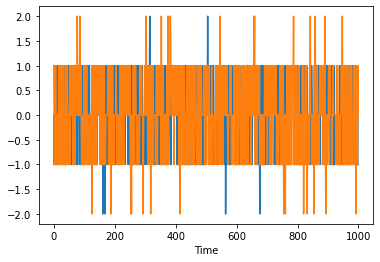

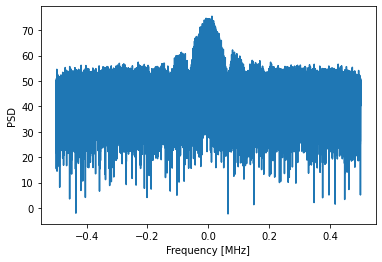

In [6]:
import numpy as np
import adi
import matplotlib.pyplot as plt

sample_rate = 1e6 # Hz
center_freq = 915e6 # Hz
num_samps = 100000 # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.3.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -50 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC

# Create transmit waveform (QPSK, 16 samples per symbol)
num_symbols = 1000
x_int = np.random.randint(0, 4, num_symbols) # 0 to 3
x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
samples = np.repeat(x_symbols, 16) # 16 samples per symbol (rectangular pulses)
samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(samples) # start transmitting

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()
print(rx_samples)

# Stop transmitting
sdr.tx_destroy_buffer()

# Calculate power spectral density (frequency domain version of signal)
psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
psd_dB = 10*np.log10(psd)
f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))

# Plot time domain
plt.figure(0)
plt.plot(np.real(rx_samples[::100]))
plt.plot(np.imag(rx_samples[::100]))
plt.xlabel("Time")

# Plot freq domain
plt.figure(1)
plt.plot(f/1e6, psd_dB)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.show()

[-1.+0.j  0.+0.j  0.+0.j ...  0.-1.j  0.-1.j  0.+0.j]


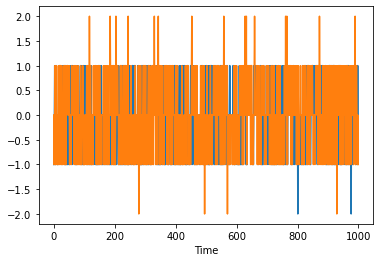

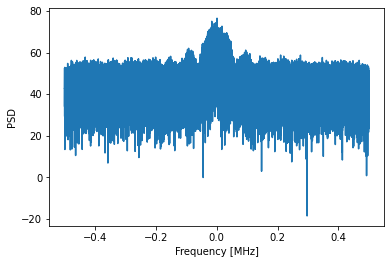

In [7]:
import numpy as np
import adi
import matplotlib.pyplot as plt

sample_rate = 1e6 # Hz
center_freq = 915e6 # Hz
num_samps = 100000 # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.3.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -50 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC

# Create transmit waveform (QPSK, 16 samples per symbol)
num_symbols = 1000
x_int = np.random.randint(0, 4, num_symbols) # 0 to 3
x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
samples = np.repeat(x_symbols, 16) # 16 samples per symbol (rectangular pulses)
samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(samples) # start transmitting

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()
print(rx_samples)

# Stop transmitting
sdr.tx_destroy_buffer()

# Calculate power spectral density (frequency domain version of signal)
psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
psd_dB = 10*np.log10(psd)
f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))

# Plot time domain
plt.figure(0)
plt.plot(np.real(rx_samples[::100]))
plt.plot(np.imag(rx_samples[::100]))
plt.xlabel("Time")

# Plot freq domain
plt.figure(1)
plt.plot(f/1e6, psd_dB)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.show()